In [28]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import torchvision
from torchvision import datasets
from torchvision import transforms


import PIL
from PIL import Image

import time

In [2]:
class SiameseNetworkDataset(data.Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)
        
#         print(img0_tuple, img1_tuple)
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [58]:
BATCH_SIZE = 64
NUM_EPOCH = 500
LRATE = 0.001

In [59]:
train_path  = 'dataset/train'
valid_path  = 'dataset/valid'


tmft_train = transforms.Compose([
    transforms.Resize((112,112)),
#     transforms.RandomRotation(30),
    transforms.CenterCrop((112)),
    transforms.Grayscale(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

tmft_valid = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.CenterCrop((112)),
    transforms.Grayscale(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

trainset_imagefolder = datasets.ImageFolder(train_path)
trainset = SiameseNetworkDataset(trainset_imagefolder, transform=tmft_train)
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

valid_imagefolder = datasets.ImageFolder(valid_path)
validset = SiameseNetworkDataset(valid_imagefolder, transform=tmft_valid)
validloader = data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [60]:

# img0_tuple = random.choice(trainset_imagefolder.imgs)
# img0_tuple
# should_get_same_class = random.randint(0,1) 
# if should_get_same_class:
#     while True:
#         #keep looping till the same class image is found
#         img1_tuple = random.choice(trainset_imagefolder.imgs) 
#         if img0_tuple[1]==img1_tuple[1]:
#             break
# else:
#     img1_tuple = random.choice(trainset_imagefolder.imgs)

# label = torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
# img0_tuple,img1_tuple, label

In [61]:
# im1, im2, sim = next(iter(trainloader))

In [62]:
# plt.imshow(im1[0].permute(1,2,0));plt.show()
# plt.imshow(im2[0].permute(1,2,0));plt.show()
# print(sim[0])

plt.imshow(im1[0].squeeze());plt.show()
plt.imshow(im2[0].squeeze());plt.show()
print(sim[0])

# im1.squeeze()

NameError: name 'im1' is not defined

In [63]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*112*112, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 32)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        if torch.cuda.is_available():
            euclidean_distance = euclidean_distance.cpu()
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [64]:
model = SiameseNetwork()
if torch.cuda.is_available():
    model = model.cuda()

criterion = ContrastiveLoss()
optimizer = optim.SGD(model.parameters(), lr=LRATE)

In [10]:
# img1, img2, label = next(iter(trainloader))

# if torch.cuda.is_available():
#     img1 = img1.cuda()
#     img2 = img2.cuda()

# optimizer.zero_grad()
# output1, output2 = model.forward(img1, img2) #forward prop
# loss = criterion(output1, output2, label)
# loss.backward()
# optimizer.step()
# print(loss)

In [19]:
torch.rand(1,2,2,2).size(0)

1

In [65]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [66]:
def train(epoch, num_epoch, model, dataloader, criterion, optimizer):
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    
    model.train()
    
    end_time = time.time()
    for idx, (img1,img2,label) in enumerate(dataloader):
        data_time.update(time.time() - end_time)
        
        if torch.cuda.is_available():
            img1 = img1.cuda()
            img2 = img2.cuda()
            
        optimizer.zero_grad()
        output1, output2 = model.forward(img1, img2) #forward prop
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        
        losses.update(loss.item(), img1.size(0))
        batch_time.update(time.time() - end_time)
        end_time = time.time()
        
        if idx % 5==0:
            print(f'Train Epoch [{epoch+1}/{num_epoch}] [{idx}/{len(dataloader)}]\t'
                  f' Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  f' Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  f' Loss {losses.val:.4f} ({losses.avg:.4f}) ')
        
    return losses.avg
        
def valid(epoch, num_epoch, model, dataloader, criterion, optimizer):
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    
    model.eval()
    with torch.no_grad():
        end_time = time.time()
        for idx, (img1,img2,label) in enumerate(dataloader):
            data_time.update(time.time() - end_time)
            
            if torch.cuda.is_available():
                img1 = img1.cuda()
                img2 = img2.cuda()

            output1, output2 = model.forward(img1, img2) #forward prop
            loss = criterion(output1, output2, label)
            
            losses.update(loss.item(), img1.size(0))
            batch_time.update(time.time() - end_time)
            end_time = time.time()
            
            if idx % 5==0:
                print(f'Valid Epoch [{epoch + 1}/{num_epoch}] [{idx}/{len(dataloader)}]\t'
                      f' Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      f' Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                      f' Loss {losses.val:.4f} ({losses.avg:.4f}) ')
            
    return losses.avg
    

In [67]:
history = {'train':[], 'valid':[]}
for epoch in range(NUM_EPOCH):
    trainloss = train(epoch, NUM_EPOCH, model, trainloader, criterion, optimizer)
    validloss = valid(epoch, NUM_EPOCH, model, validloader, criterion, optimizer)
    history['train'].append(trainloss)
    history['valid'].append(validloss)

Train Epoch [1/500] [0/5]	 Time 0.154 (0.154)	 Data 0.086 (0.086)	 Loss 1.3000 (1.3000) 
Valid Epoch [1/500] [0/2]	 Time 0.114 (0.114)	 Data 0.079 (0.079)	 Loss 2.0617 (2.0617) 
Train Epoch [2/500] [0/5]	 Time 0.127 (0.127)	 Data 0.077 (0.077)	 Loss 1.3490 (1.3490) 
Valid Epoch [2/500] [0/2]	 Time 0.117 (0.117)	 Data 0.079 (0.079)	 Loss 2.1837 (2.1837) 
Train Epoch [3/500] [0/5]	 Time 0.127 (0.127)	 Data 0.077 (0.077)	 Loss 1.3497 (1.3497) 
Valid Epoch [3/500] [0/2]	 Time 0.119 (0.119)	 Data 0.082 (0.082)	 Loss 2.0473 (2.0473) 
Train Epoch [4/500] [0/5]	 Time 0.131 (0.131)	 Data 0.079 (0.079)	 Loss 1.2961 (1.2961) 
Valid Epoch [4/500] [0/2]	 Time 0.116 (0.116)	 Data 0.079 (0.079)	 Loss 1.6513 (1.6513) 
Train Epoch [5/500] [0/5]	 Time 0.133 (0.133)	 Data 0.081 (0.081)	 Loss 1.3123 (1.3123) 
Valid Epoch [5/500] [0/2]	 Time 0.119 (0.119)	 Data 0.082 (0.082)	 Loss 1.8454 (1.8454) 
Train Epoch [6/500] [0/5]	 Time 0.129 (0.129)	 Data 0.079 (0.079)	 Loss 1.1306 (1.1306) 
Valid Epoch [6/500] [

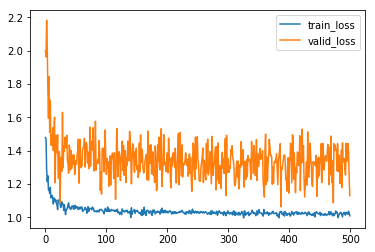

In [69]:
index = list(range(len(history['train'])))
plt.plot(index, history['train'], label='train_loss')
plt.plot(index, history['valid'], label='valid_loss')
plt.legend(loc=1)
plt.show()

In [47]:
list(range(len(history['train'])))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [76]:
im1, im2, label = next(iter(validloader))
if torch.cuda.is_available():
    im1 = im1.cuda()
    im2 = im2.cuda()
out1, out2 = model.forward(im1,im2)
predicted_label = F.pairwise_distance(out1, out2)

tensor([5.6569e-06, 6.0495e-01, 5.0297e-01, 5.3051e-01, 5.6569e-06, 6.5294e-01,
        5.6569e-06, 4.3804e-01, 5.5427e-01, 5.3990e-01, 5.6715e-01, 5.7654e-01,
        3.7444e-01, 4.4090e-01, 3.9682e-01, 5.3144e-01, 4.0418e-01, 6.2617e-01,
        7.5921e-01, 3.4267e-01, 7.9428e-01, 6.2846e-01, 4.8033e-01, 4.8033e-01,
        5.6569e-06, 5.9539e-01, 3.6036e-01, 5.6569e-06, 5.6047e-01, 5.5724e-01,
        4.6537e-01, 5.9105e-01, 8.1076e-01, 7.2388e-01, 5.9188e-01, 4.8888e-01,
        4.3800e-01, 3.4267e-01, 6.0698e-01, 6.0897e-01, 5.1728e-01, 5.4663e-01,
        4.1752e-01, 7.2045e-01, 7.2649e-01, 6.1057e-01, 6.0616e-01, 5.6569e-06,
        5.1710e-01, 6.0714e-01, 6.5112e-01, 4.1892e-01, 4.5391e-01, 5.3187e-01,
        5.0826e-01, 4.9390e-01, 5.3737e-01, 6.3637e-01, 4.3167e-01, 4.0419e-01,
        5.3574e-01, 3.4071e-01, 7.2119e-01, 3.9889e-01], device='cuda:0',
       grad_fn=<NormBackward1>)

In [90]:
def threshold(val):
    if val>0.5:
        return 1
    else:
        return 0
    

In [ ]:
model.eval()
fn, fp, ap, an = 0,0,0,0
for idx, (img1,img2,label) in enumerate(validloader):
    if torch.cuda.is_available():
        img1 = img1.cuda()
        img2 = img2.cuda()
    out1, out2 = model.forward(img1,img2)
    predicted_label = F.pairwise_distance(out1, out2)
    
    for i in range(img1.size(0)):
        pr = threshold(predicted_label[i].item())
        gt = int(label[i].item())
        
        if pr==False and gt==True: fn+=1
        elif pr==True and gt==True: ap+=1
        elif pr==False and gt==False: an+=1
        elif pr==True and gt==False: fp+=1
        
fn, fp, ap, an
error = (fn + fp) / (fp+fn+ap+an) * 100
accuracy = ap+an / (fp+fn+ap+an) * 100
accuracy, error

(87.0, 21.666666666666668)

In [113]:
1==True

True

Predicted: 1	 Ground Truth: 0.0


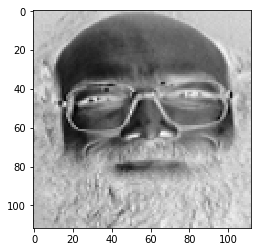

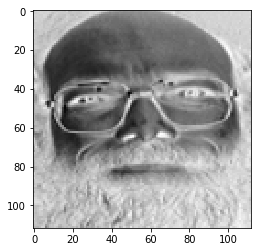

In [111]:
idx = 3
i1 = im1[idx]
i2 = im2[idx]
lbl = label[idx]
pl = threshold(predicted_label[idx].item())

print(f'Predicted: {pl}\t Ground Truth: {lbl.item()}')
plt.imshow(i1.squeeze().cpu(), cmap='gray');plt.show()
plt.imshow(i2.squeeze().cpu(), cmap='gray');plt.show()
